# A Simple Book Recommender System Using Deep Learning

## Contents

### Books File

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

### Ratings File

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

## Import the library and Fix the Seeds

In [1]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import random
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 101
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load and Clean the Data

In [2]:
ratings = pd.read_csv('Ratings.csv', low_memory=False)
books = pd.read_csv('Books.csv', low_memory=False)

In [3]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [4]:
ratings.isnull().sum()/len(ratings)*100

User-ID        0.0
ISBN           0.0
Book-Rating    0.0
dtype: float64

In [5]:
books.head()

,ISBN,Title,Author,Year,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
books.isnull().sum()/len(books)*100

ISBN           0.000000
Title          0.000000
Author         0.000369
Year           0.000000
Publisher      0.000737
Image-URL-S    0.000000
Image-URL-M    0.000000
Image-URL-L    0.001106
dtype: float64

In [7]:
books.dropna(inplace = True)
books.isnull().sum()

ISBN           0
Title          0
Author         0
Year           0
Publisher      0
Image-URL-S    0
Image-URL-M    0
Image-URL-L    0
dtype: int64

In [8]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


## Summarize the Data

<AxesSubplot:xlabel='Book-Rating', ylabel='count'>

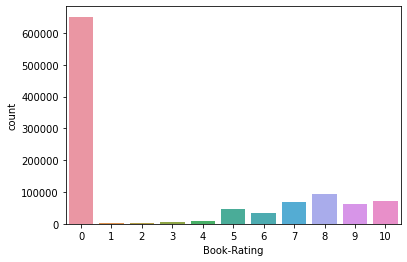

In [9]:
sns.countplot(x='Book-Rating',data = ratings)

Since there is so much noise for the values of 0, which according to the information provided with the dataset indicates "implicit", which in this case is slightly ambiguous. In regards to this issue, below I will remove these rows.

In [10]:
ratings = ratings[ratings["Book-Rating"] != 0]

<AxesSubplot:xlabel='Book-Rating', ylabel='count'>

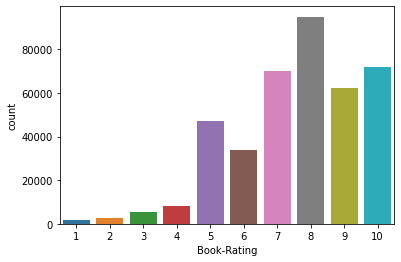

In [11]:
sns.countplot(x='Book-Rating',data = ratings)

In [12]:
ratings.head()

,User-ID,ISBN,Book-Rating
1,276726,155061224,5
3,276729,052165615X,3
4,276729,521795028,6
6,276736,3257224281,8
7,276737,600570967,6


In [13]:
# Get the unique userIds
user_ids = ratings["User-ID"].unique().tolist()
# Map userIds to the corresponding indices
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
# Inverse transform from index to userId
userencoded2user = {i: x for i, x in enumerate(user_ids)}
# Get the unique ISBN
books_ids = ratings["ISBN"].unique().tolist()
# Map ISBN to the corresponding index
books2books_encoded = {x: i for i, x in enumerate(books_ids)}
# Inverse transform from index to userId
books_encoded2books = {i: x for i, x in enumerate(books_ids)}
ratings["User-ID"] = ratings["User-ID"].map(user2user_encoded)
ratings["ISBN"] = ratings["ISBN"].map(books2books_encoded)

num_users = len(user2user_encoded)
num_books = len(books_encoded2books)
unique_rating = ratings["Book-Rating"].unique().tolist()
ratings["Book-Rating"] = ratings["Book-Rating"].values.astype(np.float32)


print(f"Number of users: {num_users}, Number of Books: {num_books}")
print(f"The unique rating values = {sorted(unique_rating)}")

Number of users: 70642, Number of Books: 174921
The unique rating values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Split the Data into Training and Test Dataset

We take out the features and label. We convert the label to the range of [0, 1] to improve the network's performance.

In [14]:
X = ratings[["User-ID", "ISBN"]].values
# Normalize the targets between 0 and 1. 
scaler = MinMaxScaler()
y = scaler.fit_transform(ratings["Book-Rating"].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 101)

In [15]:
# Set the dimensionaliy of the embedding space
EMBEDDING_SIZE = 50

# Create a subclass from Model class
class RecommenderNet(keras.Model):
    # construct the layers in the constructor
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        # Map userIds to  smaller vector space
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1),
        )
        # Generate a bias 
        self.user_bias = layers.Embedding(num_users, 1)
        # Map ISBN to  smaller vector space
        self.books_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1),
        )
        # Book bias
        self.books_bias = layers.Embedding(num_books, 1)
    # The forward pass to do computation
    def call(self, inputs):
        # Take out the first feature of userIds and do embedding
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # Take out the 2nd feature of ISBN and do embedding
        books_vector = self.books_embedding(inputs[:, 1])
        books_bias = self.books_bias(inputs[:, 1])
        # 
        dot_user_books = tf.tensordot(user_vector, books_vector, 2)
        # Add all the components (including bias)
        x = dot_user_books + user_bias + books_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

# Create the model based on the sublass defined above
model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)

## Configure the Model

There are only two cases for the label. It either recommends the book or doesn't recommend it. It is a binary classification. The loss function should be binary cross-entropy. We also need to specify the optimizer.

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

## Train the Model

We train the model using early stopping.

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0.001, 
    mode='min')
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size= 128,
    epochs=100,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping])

Epoch 1/100
2483/2483 [==============================] - 16s 6ms/step - loss: 0.9831 - val_loss: 0.6334
Epoch 2/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.6186 - val_loss: 0.6186
Epoch 3/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.5965 - val_loss: 0.6031
Epoch 4/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.5790 - val_loss: 0.5890
Epoch 5/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.5684 - val_loss: 0.5826
Epoch 6/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.5607 - val_loss: 0.5785
Epoch 7/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.5548 - val_loss: 0.5761
Epoch 8/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.5501 - val_loss: 0.5745
Epoch 9/100
2483/2483 [==============================] - 15s 6ms/step - loss: 0.5461 - val_loss: 0.5735
Epoch 10/100
2483/2483 [==============================] - 15s 6m

In [18]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  3532100   
                                                                 
 embedding_1 (Embedding)     multiple                  70642     
                                                                 
 embedding_2 (Embedding)     multiple                  8746050   
                                                                 
 embedding_3 (Embedding)     multiple                  174921    
                                                                 
Total params: 12,523,713
Trainable params: 12,523,713
Non-trainable params: 0
_________________________________________________________________


## Model Diagnostics

Let's check the in sample fit and out sample fit.

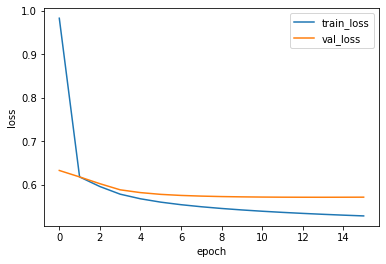

In [19]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

## Recommend Books

The recommender system only can forecast it for the existing users in the dataset. Let's randomly select a user and recommend several books for him/her.

In [20]:
# Randomly select a user from the rating dataset
from random import sample
user_id = str(random.sample(set(user_ids), 1))[1:-1]
print(user_id)

44739


In [21]:
# Subset the books read and not read by this user
books_read_by_user = ratings[ratings["User-ID"] == user_id]
books_not_read = books[~books["ISBN"].isin(books_read_by_user.ISBN.values)]["ISBN"]
# Find the books not read that contains in the rating dataset
books_not_read = list(set(books_not_read).intersection(set(books2books_encoded.keys())))
# Map  the books to the indices
books_not_read = [[books2books_encoded.get(x)] for x in books_not_read]
# Map the user Id to the index
user_encoder = user2user_encoded.get(int(user_id))
# Generate a dataset with two columns
# The first column is the user_encoder that is the same for all rows
# The 2nd column is the books not read by this user.
user_books_array = np.hstack(([[user_encoder]] * len(books_not_read), books_not_read))
# Forecast the ratings(probablity of this user will read it )
ratings = model.predict(user_books_array).flatten()
# Find the indices of the top 10 ratings by using argsort
top_ratings_indices = ratings.argsort()[-10:][::-1]
# Find the recommened book Ids
recommended_books_ids = [books_encoded2books.get(books_not_read[x][0]) for x in top_ratings_indices]

In [22]:
# Below, I only chose to show the Top 10 Recommendations, however if somebody wanted to 
#             show the "Top 10 Books rated by the User" I provided the code below as well. 

# print("Showing recommendations for user: {}".format(user_id))
#print(f"Showing recommendations for user: {user_id}")
#print("====" * 20)
#print("Top 10 Books with high ratings from user")
#print("----" * 20)
#top_books_user = (books_read_by_user.sort_values(by="Book-Rating", ascending=False).head(10).ISBN.values)
#books_rows = books[books["ISBN"].isin(top_books_user)]
#for row in books_rows.itertuples():
#print(f"The title: {row.Title}; Author: {row.Author}; Published: {row.Year}")
print("----" * 20)
print("Top 10 Books recommendations")
print("----" * 20)
recommended_books = books[books["ISBN"].isin(recommended_books_ids)]
for row in recommended_books.itertuples():
    print(f"The title: {row.Title}; Author: {row.Author}; Published: {row.Year}")

--------------------------------------------------------------------------------
Top 10 Books recommendations
--------------------------------------------------------------------------------
The title: Where the Sidewalk Ends : Poems and Drawings; Author: Shel Silverstein; Published: 1974
The title: 84 Charing Cross Road; Author: Helene Hanff; Published: 1990
The title: Fox in Socks (I Can Read It All by Myself Beginner Books); Author: Dr. Seuss; Published: 1965
The title: The Two Towers (The Lord of the Rings, Part 2); Author: J. R. R. Tolkien; Published: 1999
The title: The Giving Tree; Author: Shel Silverstein; Published: 1964
The title: Calvin and Hobbes; Author: Bill Watterson; Published: 1987
The title: My Sister's Keeper : A Novel (Picoult, Jodi); Author: Jodi Picoult; Published: 2004
The title: Dilbert: A Book of Postcards; Author: Scott Adams; Published: 1996
The title: Harry Potter and the Chamber of Secrets Postcard Book; Author: J. K. Rowling; Published: 2002
The title: The